# Audit Risk Analysis

## 1.0 Import and install python libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from collections import Counter
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')
random_seed = 1
np.random.seed(random_seed)

In [2]:
import tensorflow as tf
from tensorflow import keras

import keras.backend as K
import sys
from scikeras.wrappers import KerasClassifier
from keras.initializers import GlorotNormal
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score,classification_report, make_scorer
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
sys.setrecursionlimit(10000)

### Setting up the required directory

In [4]:
import os
os.chdir("D:/BAIS/2nd Sem/DSP")

print(os.getcwd())

D:\BAIS\2nd Sem\DSP


## 2. Load data

We have already cleaned and processed the data in previous file

In [3]:
X_train = pd.read_csv('C:/Users/simra/Downloads/audit1_train_X1.csv') 
y_train = pd.read_csv('C:/Users/simra/Downloads/audit1_train_y1.csv') 
y_test = pd.read_csv('C:/Users/simra/Downloads/audit1_test_y1.csv') 
X_test = pd.read_csv('C:/Users/simra/Downloads/audit1_test_X1.csv') 

## 3. Model the data
First, let's create a dataframe to load the model performance metrics into.


In [4]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

In [5]:
X_train.isna().sum()

Sector_score     0
PARA_A           0
Score_A          0
Risk_A           0
PARA_B           0
Score_B          0
Risk_B           0
numbers          0
Score_B.1        0
Risk_C           0
Money_Value      0
Score_MV         0
Risk_D           0
District_Loss    0
PROB             0
RiSk_E           0
History          0
Prob             0
Risk_F           0
Score            0
CONTROL_RISK     0
dtype: int64

### 3.1  Logistic Regression 

### 3.1.1 Logistic Regression Random Search CV using default,L1,L2,Elastic,liblinear regularization

Conduct an initial random search across a wide range of possible parameters.

In [9]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'max_iter':np.arange(500,1000),
    'penalty': ['None','l1','l2','elasticnet'],
    'solver':['saga','liblinear']
}

log_reg_model = LogisticRegression()
rand_search = RandomizedSearchCV(estimator = log_reg_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best recall score is 0.9782692307692308
... with parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 867}


### 3.1.2 Logistic Regression Grid Search CV using default,L1,L2,Elastic,liblinear regularization

In [10]:
score_measure = "recall"
kfolds = 5
max_iter = rand_search.best_params_['max_iter']
penalty = rand_search.best_params_['penalty']
solver = rand_search.best_params_['solver']

param_grid = {
    'max_iter': np.arange(max_iter-5,max_iter+5),  
    'penalty': [penalty],
    'solver': [solver]
}

log_reg_model = LogisticRegression()
grid_search = GridSearchCV(estimator = log_reg_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallLogistic = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best recall score is 0.9782692307692308
... with parameters: {'max_iter': 862, 'penalty': 'l1', 'solver': 'saga'}


In [11]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Regression", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 3.2  Support Vector Machine 

### 3.2.1 SVM Random Search CV using linear, rbf and poly kernal


In [15]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'C': np.arange(1,25),   
    'gamma': ['scale','auto'],
    'kernel':['linear','rbf','poly']
}

svm_model = SVC()
rand_search = RandomizedSearchCV(estimator = svm_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
The best recall score is 0.9906730769230769
... with parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 23}


### 3.2.2 SVM Grid Search CV using linear, rbf and poly kernal


In [16]:
score_measure = "recall"
kfolds = 5

C = rand_search.best_params_['C']
gamma = rand_search.best_params_['gamma']
kernel = rand_search.best_params_['kernel']

param_grid = {
    'C': np.arange(C-2,C+2),  
    'gamma': [gamma],
    'kernel': [kernel]
    
}

svm_model = SVC()
grid_search = GridSearchCV(estimator = svm_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallSVM = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best recall score is 0.9906730769230769
... with parameters: {'C': 23, 'gamma': 'scale', 'kernel': 'linear'}


In [17]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## 3.3 Decision Tree

### 3.3.1 DTree Random Search CV

In [18]:
score_measure = "recall"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best recall score is 0.9969230769230769
... with parameters: {'min_samples_split': 73, 'min_samples_leaf': 94, 'min_impurity_decrease': 0.0031, 'max_leaf_nodes': 31, 'max_depth': 3, 'criterion': 'entropy'}


### 3.3.2 DTree Grid Search CV

In [19]:
score_measure = "recall"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
The best recall score is 0.9969230769230769
... with parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_leaf_nodes': 29, 'min_impurity_decrease': 0.003, 'min_samples_leaf': 92, 'min_samples_split': 71}


In [20]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 3.3.3 Diagrams of the Dtree:


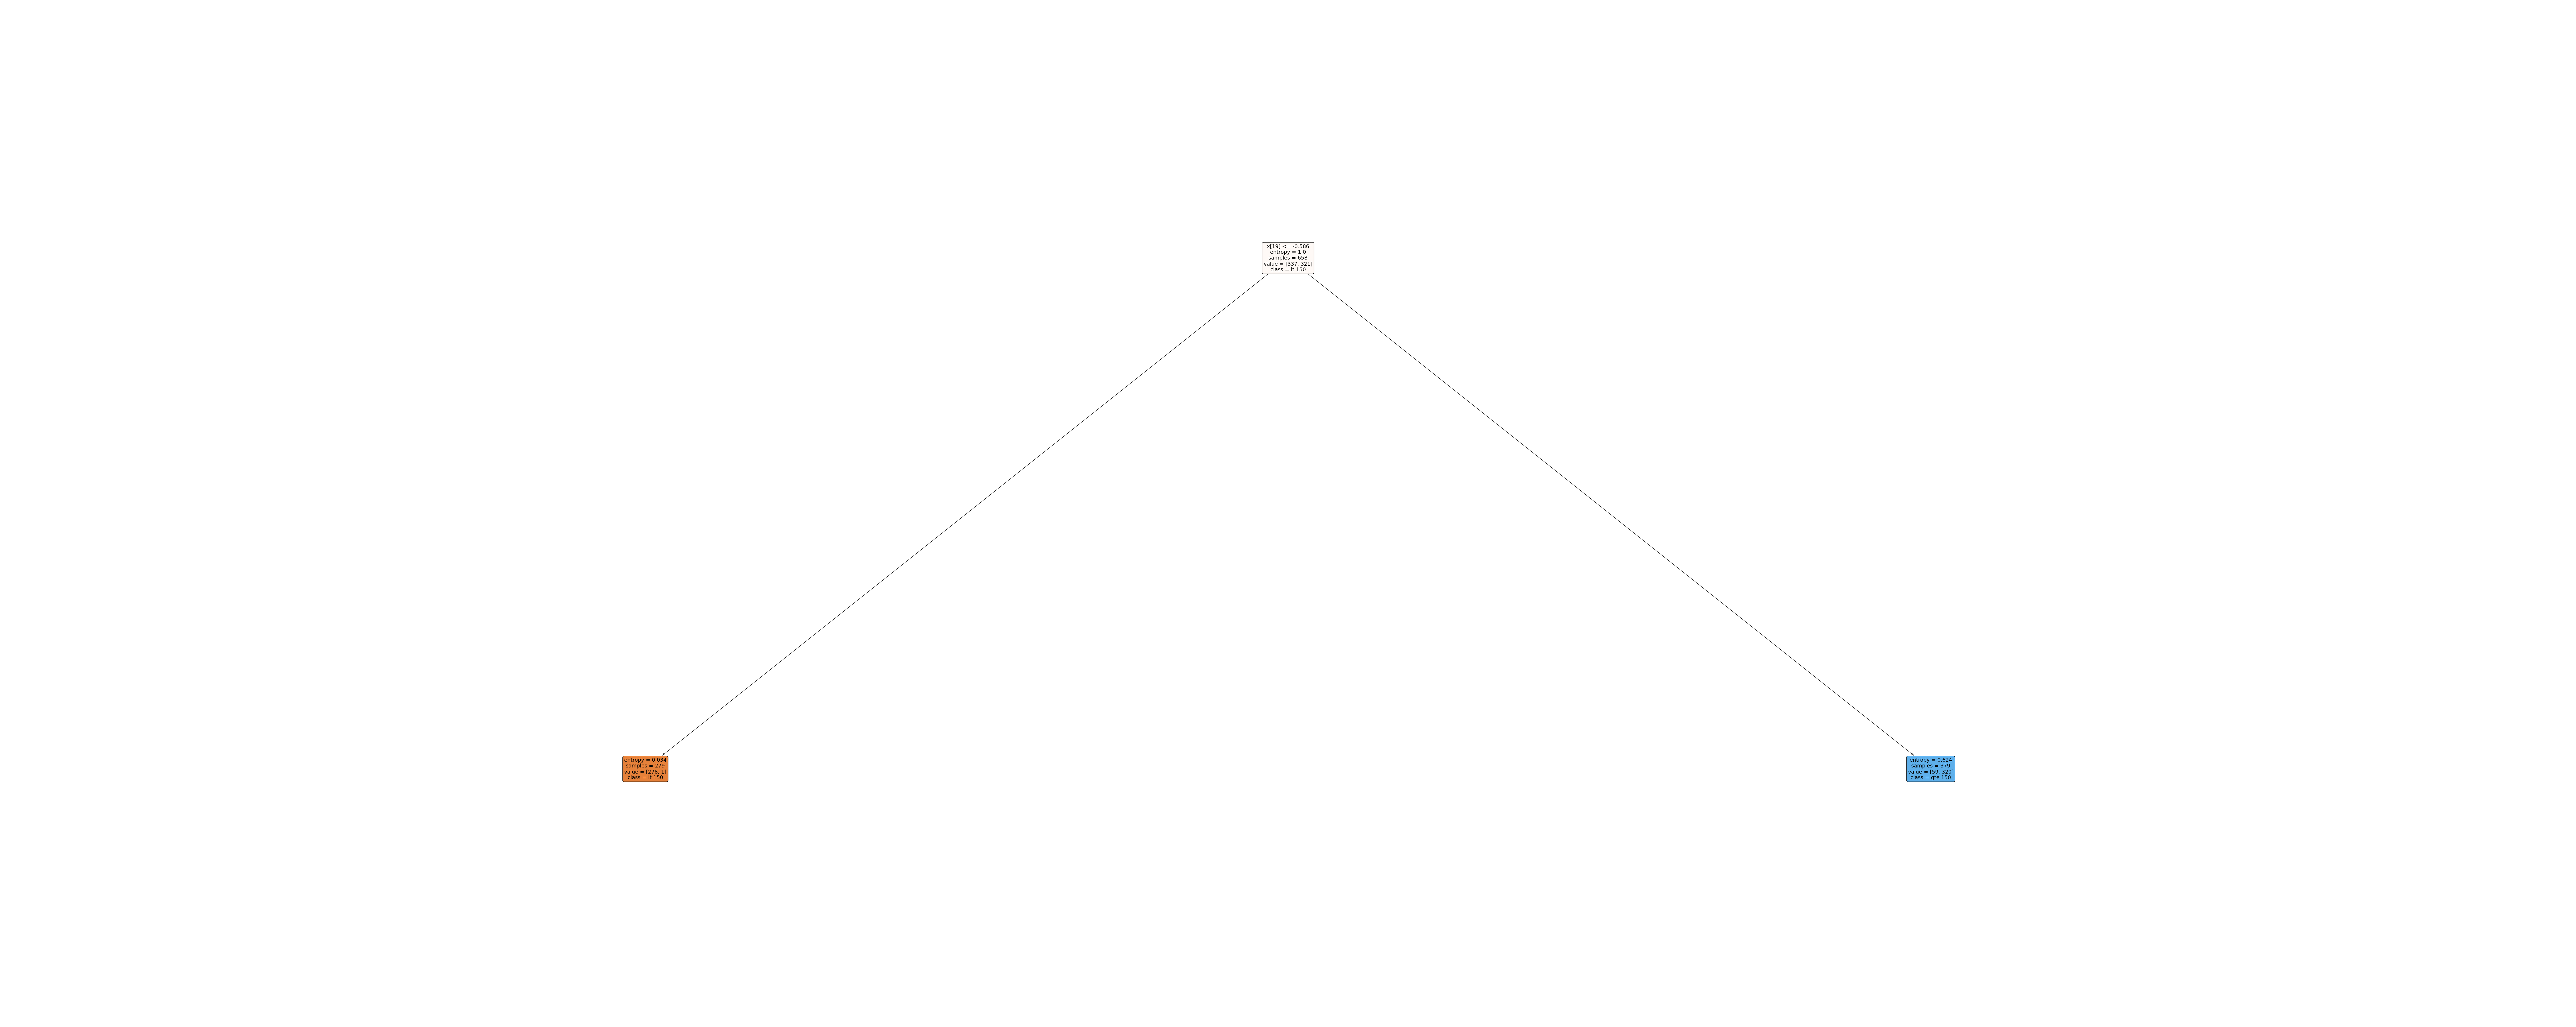

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_,
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

### 3.4  Neural Network 

### 3.4.1 Neural Net Random Search CV 

Conduct an initial random search across a wide range of possible parameters.

In [22]:
%%time 

score_measure = "recall"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20), (60,40, 20)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2],
    'max_iter': [5000]
}

ann = MLPClassifier()
rand_search = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

bestRecallTree = rand_search.best_estimator_

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best recall score is 0.9875961538461538
... with parameters: {'solver': 'adam', 'max_iter': 5000, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (70,), 'alpha': 0, 'activation': 'tanh'}
CPU times: total: 1.8 s
Wall time: 1min 24s


### 3.4.2 Neural Net Grid Search CV 

Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [23]:
score_measure = "recall"
kfolds = 5

hidden_layer_sizes = rand_search.best_params_['hidden_layer_sizes']
activation = rand_search.best_params_['activation']
solver = rand_search.best_params_['solver']
alpha = rand_search.best_params_['alpha']
learning_rate = rand_search.best_params_['learning_rate']
learning_rate_init = rand_search.best_params_['learning_rate_init']
max_iter = rand_search.best_params_['max_iter']

param_grid = {
    'hidden_layer_sizes': [hidden_layer_sizes],  
    'activation': [activation],
    'solver': [solver],
    'alpha': np.arange(alpha,alpha+1,.2),
    'learning_rate': [learning_rate],
    'learning_rate_init': np.arange(learning_rate_init-0.1,learning_rate_init+0.1,.005),
    'max_iter' : np.arange(max_iter-100,max_iter+100,10)
}

ann = MLPClassifier()
grid_search = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallNeuralNet = grid_search.best_estimator_

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
The best recall score is 0.993798076923077
... with parameters: {'activation': 'tanh', 'alpha': 0.2, 'hidden_layer_sizes': (70,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.030000000000000096, 'max_iter': 5080, 'solver': 'adam'}


In [40]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Neural Network", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

## 3.5 Keras Technique

In [29]:
X_train.head()

,Sector_score,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,numbers,Score_B.1,Risk_C,...,Score_MV,Risk_D,District_Loss,PROB,RiSk_E,History,Prob,Risk_F,Score,CONTROL_RISK
0,-0.676738,-0.535546,-0.968936,-0.492387,-0.446426,-0.732370,-0.433674,-0.270942,-0.330765,-0.315077,...,-0.661166,-0.209479,-0.432066,-0.154728,-0.439594,-0.244898,-0.283472,-0.219281,-0.927697,-0.427765
1,0.115405,-0.413534,-0.968936,-0.452243,-0.421190,-0.732370,-0.425292,-0.270942,-0.330765,-0.315077,...,-0.661166,-0.209479,-0.432066,-0.154728,-0.439594,-0.244898,-0.283472,-0.219281,-0.927697,-0.427765
2,-0.627675,-0.535546,-0.968936,-0.492387,-0.174041,0.398849,-0.252730,-0.270942,-0.330765,-0.315077,...,1.690440,0.411609,-0.432066,-0.154728,-0.439594,-0.244898,-0.283472,-0.219281,0.210306,-0.427765
3,1.539501,-0.195514,0.155508,-0.268630,-0.209692,1.530068,-0.197782,-0.270942,-0.330765,-0.315077,...,-0.661166,-0.193574,1.130020,-0.154728,0.951045,-0.244898,-0.283472,-0.219281,0.893108,0.450454
4,-0.627675,0.948593,1.279953,0.972563,-0.356699,-0.732370,-0.403872,-0.270942,-0.330765,-0.315077,...,-0.661166,-0.204076,-0.432066,-0.154728,-0.439594,-0.244898,-0.283472,-0.219281,-0.472496,-0.427765


In [32]:
# Define recall metric function
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Define the model
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=21))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile model
#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[recall])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=21)),
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    ann.compile(loss = 'binary_crossentropy', metrics = [recall])
    return ann

Epoch 1/20
7/7 [==============================] - 1s 78ms/step - loss: 0.2457 - recall: 0.9026 - val_loss: 0.0664 - val_recall: 1.0000
Epoch 2/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0630 - recall: 0.9788 - val_loss: 0.1021 - val_recall: 0.9942
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0845 - recall: 0.9690 - val_loss: 0.0786 - val_recall: 0.9942
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0409 - recall: 0.9778 - val_loss: 0.0409 - val_recall: 0.9802
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 0.0446 - recall: 0.9889 - val_loss: 0.0371 - val_recall: 0.9802
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0457 - recall: 0.9783 - val_loss: 0.0468 - val_recall: 0.9942
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0369 - recall: 0.9912 - val_loss: 0.0385 - val_recall: 0.9802
Epoch 8/20
7/7 [==============================] - 0s 12

### 3.5.1 Keras Technique Random Search CV

In [33]:
score_measure = recall
kfolds = 5

param_grid = {
    'optimizer__learning_rate': [0.0005, 0.001],
    'model__hidden_layer_sizes': [(70,),(90, )],
    'model__dropout': [0, 0.1],
    'batch_size':[20, 60],
    'epochs':[10, 50],
    'optimizer':["adam",'sgd']
}

keras_clf = KerasClassifier(model=build_clf, hidden_layer_sizes=21, dropout = 0.0)
keras_clf.get_params().keys()

rand_search = RandomizedSearchCV(estimator=keras_clf, param_distributions=param_grid, scoring=score_measure, 
                                 n_iter=20, cv=kfolds)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
callback = [earlystop]

_ = rand_search.fit(X_train, y_train, callbacks=callback, verbose=0)

print(f"The best recall score is with parameters: {rand_search.best_params_}")

The best recall score is with parameters: {'optimizer__learning_rate': 0.001, 'optimizer': 'sgd', 'model__hidden_layer_sizes': (70,), 'model__dropout': 0, 'epochs': 10, 'batch_size': 60}


In [34]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Keras", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

5/5 [==============================] - 0s 3ms/step


## 6.0 Summary


Recall is important in audit risk prediction analysis because it measures the ability of the model to identify all actual positive cases (high Risk) of financial misstatements, which is critical in ensuring audit quality.

In audit risk analysis, the consequences of failing to identify a financial misstatement can be severe, resulting in significant reputational and financial risks for the audit firm and its clients. Therefore, it is important to identify as many financial misstatements as possible.

High recall means that the model is correctly identifying a large proportion of actual financial misstatements, reducing the risk of material misstatements going undetected. This is especially important in high-risk industries or in cases where there is a high likelihood of financial misstatements due to factors such as complex transactions, high levels of estimation uncertainty, or management incentives to manipulate financial statements.

Sorted by Recall, the best models are:

In [41]:
performance.sort_values(by=['Recall'])

,model,Accuracy,Precision,Recall,F1
0,Keras,0.797872,0.903509,0.691275,0.783270
0,Logistic Regression,0.971631,0.966887,0.979866,0.973333
0,Neural Network,0.978723,0.979866,0.979866,0.979866
0,SVM,0.992908,0.986755,1.000000,0.993333
0,SVM,0.992908,0.986755,1.000000,0.993333
0,Decision Tree,0.907801,0.851429,1.000000,0.919753


## 6.1 Analysis


Recall value has been taken here in consideration to give FN more weight than the FP.
Recall is important in audit risk prediction analysis because it measures the ability of the model to identify all actual positive cases of financial misstatements, which is critical in ensuring audit quality.


As per the matrix, Recall value for Decision tree is highest i.e. 1.
Hence, we can use Decision Tree for audit risk prediction. But recall value is same for Decision Tree and SVM i.e 1. In that case, we can also move to precision to decide out best model. 
Since, precision focuses more on false positives which will help us avoid false positive cases of financial misstatement and ruining the reputation of the companies which do not posses a high risk.
So, considering all the above factors, precision is higher for SVM which is 0.986755 higher than Decision Tree which is 0.851429. 
Comparing it with Neural Network which had a recall value of 0.979866 and Keras techniques using random search which has a recall value of 0.691275 the results and prediction are better for SVM model.
Hence, we will use SVM model for our audit risk prediction

We are succesfully able to predict which companies have higher fault risk on the basis of the dataset. Hence these models can be used for companies fraudulent risk prediction which eventually can save a lot of monetary losses for stakeholders and investors.